In [1]:
import fastai
from fastai.tabular import *
import pandas as pd
from sklearn.metrics import roc_auc_score as roc

In [2]:
dtypes = {'ProductName': 'category',
 'IsBeta': 'category',
 'RtpStateBitfield': 'category',
 'IsSxsPassiveMode': 'category',
 'DefaultBrowsersIdentifier': 'category',
 'AVProductStatesIdentifier': 'category',
 'AVProductsInstalled': 'category',
 'AVProductsEnabled': 'category',
 'HasTpm': 'category',
 'CountryIdentifier': 'category',
 'CityIdentifier': 'category',
 'OrganizationIdentifier': 'category',
 'GeoNameIdentifier': 'category',
 'LocaleEnglishNameIdentifier': 'category',
 'Platform': 'category',
 'Processor': 'category',
 'OsBuild': 'category',
 'OsSuite': 'category',
 'OsPlatformSubRelease': 'category',
 'OsBuildLab': 'category',
 'SkuEdition': 'category',
 'IsProtected': 'category',
 'AutoSampleOptIn': 'category',
 'PuaMode': 'category',
 'SMode': 'category',
 'IeVerIdentifier': 'category',
 'SmartScreen': 'category',
 'Firewall': 'category',
 'UacLuaenable': 'category',
 'Census_MDC2FormFactor': 'category',
 'Census_DeviceFamily': 'category',
 'Census_OEMNameIdentifier': 'category',
 'Census_OEMModelIdentifier': 'category',
 'Census_ProcessorCoreCount': 'category',
 'Census_ProcessorManufacturerIdentifier': 'category',
 'Census_ProcessorModelIdentifier': 'category',
 'Census_ProcessorClass': 'category',
 'Census_PrimaryDiskTotalCapacity': 'category',
 'Census_PrimaryDiskTypeName': 'category',
 'Census_SystemVolumeTotalCapacity': 'category',
 'Census_HasOpticalDiskDrive': 'category',
 'Census_TotalPhysicalRAM': 'category',
 'Census_ChassisTypeName': 'category',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches': 'category',
 'Census_InternalPrimaryDisplayResolutionHorizontal': 'category',
 'Census_InternalPrimaryDisplayResolutionVertical': 'category',
 'Census_PowerPlatformRoleName': 'category',
 'Census_InternalBatteryType': 'category',
 'Census_InternalBatteryNumberOfCharges': 'category',
 'Census_OSVersion': 'category',
 'Census_OSArchitecture': 'category',
 'Census_OSBranch': 'category',
 'Census_OSBuildNumber': 'category',
 'Census_OSBuildRevision': 'category',
 'Census_OSEdition': 'category',
 'Census_OSSkuName': 'category',
 'Census_OSInstallTypeName': 'category',
 'Census_OSInstallLanguageIdentifier': 'category',
 'Census_OSUILocaleIdentifier': 'category',
 'Census_OSWUAutoUpdateOptionsName': 'category',
 'Census_IsPortableOperatingSystem': 'category',
 'Census_GenuineStateName': 'category',
 'Census_ActivationChannel': 'category',
 'Census_IsFlightingInternal': 'category',
 'Census_IsFlightsDisabled': 'category',
 'Census_FlightRing': 'category',
 'Census_ThresholdOptIn': 'category',
 'Census_FirmwareManufacturerIdentifier': 'category',
 'Census_FirmwareVersionIdentifier': 'category',
 'Census_IsSecureBootEnabled': 'category',
 'Census_IsWIMBootEnabled': 'category',
 'Census_IsVirtualDevice': 'category',
 'Census_IsTouchEnabled': 'category',
 'Census_IsPenCapable': 'category',
 'Census_IsAlwaysOnAlwaysConnectedCapable': 'category',
 'Wdft_IsGamer': 'category',
 'Wdft_RegionIdentifier': 'category',
 'Year': 'category',
 'Month': 'category',
 'Week': 'category',
 'Day': 'category',
 'Dayofweek': 'category',
 'Dayofyear': 'category',
 'Is_month_end': 'category',
 'Is_month_start': 'category',
 'Is_quarter_end': 'category',
 'Is_quarter_start': 'category',
 'Is_year_end': 'category',
 'Is_year_start': 'category',
 'AppVersion.cat': 'category',
 'OsVer.cat.0': 'category',
 'OsVer.cat.1': 'category',
 'OsVer.cat.2': 'category',
 'OsVer.cat.3': 'category',
 'EngineVersion' : 'category',
 'AppVersion': 'category',
 'AvSigVersion': 'category',
         }

# Training

### Few steps of data prep

In [3]:
# if you have run encoding_v2.ipynb
df_tr = pd.read_csv('tr_enc_big.csv',dtype = dtypes)

# if you have run encoding.ipynb
#df_tr = pd.read_csv('tr_enc.csv',dtype = dtypes)

In [4]:
# storing non-categorical variables 
dtp = df_tr.dtypes.apply(lambda x: x.name).to_dict()
dtp = {k : v for k,v in dtp.items() if (v != 'category') & (k != 'HasDetections') & (k != 'valid_idx')}
dtp

{'Elapsed': 'float64',
 'AvSigVersion.norm.0': 'float64',
 'AvSigVersion.norm.1': 'float64',
 'Census_FirmwareVersionIdentifier.norm': 'float64',
 'EngineVersion.norm.0': 'float64',
 'EngineVersion.norm.1': 'float64',
 'AppVersion.norm.0': 'float64',
 'AppVersion.norm.1': 'float64',
 'val': 'int64'}

In [5]:
# Float32 needed for nn
for c in dtp.keys() :
    df_tr[c] = df_tr[c].astype('float32')

# Validation indices computed in Encoding_v2.ipynb
df_tr['valid_idx'] = df_tr['valid_idx'].astype(int)

In [28]:
# sample small df for parameter tuning
trs = 200000
n = 0
sdf = df_tr.iloc[n*trs:(n+1)*trs,:]
# sdf = df_tr.sample(trs)
sdf = sdf.reset_index(drop=True)

# Getting indices of the rows used as validation test.
# These are rows with a recent AV signature, which
# looks like the test set. It's been added in Encoding_V2
valid_idx = sdf[sdf['valid_idx'] == 1].index.tolist()
sdf.drop(columns = ['valid_idx'],inplace=True)

print(f"Proportion of data used for validation: {round(100*len(valid_idx)/trs,2)}%")

Proportion of data used for validation: 44.77%


In [29]:
dep_var = 'HasDetections'
cat_cols = [c for c in sdf if (c != dep_var) & (c not in dtp.keys())]

In [47]:
# Storing the data in torch tensors & stuff

data = (TabularList.from_df(sdf, cat_names=cat_cols) 
                           .split_by_idx(list(valid_idx)) # splitting train/val
                           .label_from_df(cols=dep_var) # y = 'HasDetection'
                           #.add_test(test) # No test set, we don't want to predict yet
                           .databunch()) # data ready for fastai models


## Defining the model

### Model architecture:
Each categorical variable goes into a separate [Embedding matrix](https://www.fast.ai/2018/04/29/categorical-embeddings/). tl;dr categories (ints) are mapped into a real valued vectors (0-mean 1-std) using some lookup in "embedding matrices" that are learnt during training, so that categories can be used by nns without doing one-hot-encoding and adding 1000 billion columns to the dataset. <br>
These vectors (one vector per categorical variable, each vector possibly of different length depending on the cardinality of the variable) are then concatenated together, and concatenated with the real valued variables, 'AvSigVersion.norm.0': 'float64' etc. <br>
This part is done automatically by fastai's library, by properly labelling categorical variables and passing the list to the "DataBunch" created in the above cell. You can consider that given, no need to tune much except the encoding of variables, to manage their cardinality and the size of the embedding matrices created on the fly (number of rows = cardinality of the feature, number of columns ~= max(200,cardinality/2) or similar heuristic) <br>
<br>
Using the encoding from Encoder.ipynb, the concatenation of these vectors gives a vector of size ~1k5 or something. Using Encoder_V2.ipynb it gives a vector of size ~2k5 or something, because cat variables have a higher cardinality. Consider this as the input of the neural net, and keep in mind the size of the input when experimenting with architectures. The output of the neural network is a single number, the probabiltiy that a machine is going to be infected by a malware<br>
Now that the input of the neural network is defined, things you can tune without too much pytorch programming: <br>
<ul>
    <li> The number of layers of the neural network. </li>
    <li> The number of neurons per layer. </li>
    <li> Regularization (dropout, weight decay) </li>
    <li> Batch size </li>
    <li> Learning rate of the training, number of epochs, batch size </li>
<ul>

In [48]:
"""
Code sample for 3 layer neural network with minimal tuning.

First layer (connected to the length 1k5 or 2k6 input) has size 500, second layer 300, last layer 100.
The output of the last layer is used to compute the probabiltiy of malware infection.

Some dropout is added. Probability(dropout) of the 1st layer is 0.05, second layer 0.05, third layer 0.1.
That represents the probabiltiy that, during training, neurons's output are randomly put to 0.
It prevents the nn from memorizing stuff from the training set. It has to find pattern instead of memorizing.
"""

layers = [500, 300, 100]
ps = [0.05, 0.05, 0.1]
learn = tabular_learner(data, layers=layers, ps = ps)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


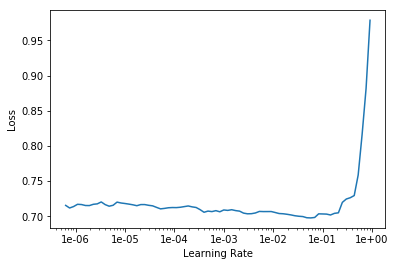

In [49]:
"""
Searching for a learning rate.
The plot shows the loss against the learning rate (growing exponentially)
"""
learn.lr_find()
learn.recorder.plot()

Pick a learning rate ~10⁻1 before the loss grows up, works well generally

In [50]:
# Train

lr = 1e-2
num_epochs = 1
learn.fit_one_cycle(num_epochs, lr)


epoch,train_loss,valid_loss
1,0.616088,0.646929


In [51]:
# roc score on validation set (data not seen during training)

ytrue = sdf['HasDetections'].iloc[valid_idx] 
ypred = learn.get_preds(DatasetType.Valid)
"""
ypred is a list of 2 tensors:
The first tensor is, for each sample of the val set,
a tuple (Prob(malware ==0), Prob(malware == 1)).
To submit stuff to kaggle, you need to submit Prob(malware == 1)
The second tensor is the predicted class (1 = malware, 0 = no malware)
for all examples of the validation set.
"""
ypred = ypred[0].numpy()[:,1] # first tensor to numpy, element 1 of tuples
roc(ytrue,ypred) # roc score - kaggle metric

0.6708438364389848

Now your nn "learn" is still in the same state. <br>
You can either save the weights & stuff for later: <br> <br>
learn.save('learn_pth') <br>
learn.export("learn.pkl") <br>
And load later: <br>
learn = load_learner(path = '.', fname = 'learn.pkl') <br>
learn = learn.load('learn_pth') <br>
learn.data = data # whatever DataBunch you create <br>
And then continue training or make predictions <br><br>
Or continue training and see if stuff improve:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


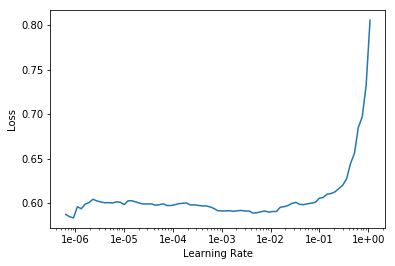

In [52]:
# Continue training a bit, find a good lr
learn.lr_find()
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss
1,0.575952,0.658876


In [55]:
# val loss is worse than after 1st epoch, train loss is better, overfitting happened

In [56]:
ypred = learn.get_preds(DatasetType.Valid)
ypred = ypred[0].numpy()[:,1]
roc(ytrue,ypred)
# roc score is also worse than after 1st epoch

0.6599420505235827

In [ ]:
# Save model for later reuse
#learn.save('learn_pth') #i think its needed for resuming training but not sure
#learn.export("learn.pkl") #needed to make preds

# Making preds

In [31]:
# Tried using gpu for inference, mem error
# Tried CPU with:
#defaults.device = torch.device('cuda')
#learn.model.to("cud")
# Other type of error
# Current solution, predict by batch and concat

In [6]:
df_te = pd.read_csv('te_enc_big.csv',dtype = dtypes)

In [7]:
dtp = df_te.dtypes.apply(lambda x: x.name).to_dict()
dtp = {k : v for k,v in dtp.items() if (v != 'category') & (k != 'HasDetections')}
dtp

{'Elapsed': 'float64',
 'AvSigVersion.norm.0': 'float64',
 'AvSigVersion.norm.1': 'float64',
 'Census_FirmwareVersionIdentifier.norm': 'float64',
 'EngineVersion.norm.0': 'float64',
 'EngineVersion.norm.1': 'float64',
 'AppVersion.norm.0': 'float64',
 'AppVersion.norm.1': 'float64'}

In [8]:
# float32 needed for nn
for c in dtp.keys() :
    df_te[c] = df_te[c].astype('float32')
    
#### required, and required to load the full train set to have all cats
#### otherwise identical cats from the test set and train set won't be mapped to
#### the same integers, and preds are random
df_tr = pd.read_csv('tr_enc_big.csv',dtype = dtypes)
for c in df_te.select_dtypes(include='category').columns :
    df_te[c] = df_te[c].cat.set_categories(df_tr[c].cat.categories)

In [9]:
cat_cols = list(dtypes.keys())
df_tr = df_tr.iloc[0:1,:] # we just needed categories to map them to the test set


In [10]:
te = TabularList.from_df(df_te.iloc[:2000000,:], cat_names=cat_cols) # 1st batch of test set
learn = load_learner(path = '.',test = te,fname="learn.pkl") # getting saved nn
pre,y = learn.get_preds(ds_type = DatasetType.Test) # preds
pre0 = pre.numpy()[:,1] # Pr(malware==1) torch tensor to numpy

In [11]:
te = TabularList.from_df(df_te.iloc[2000000:4000000,:], cat_names=cat_cols)
learn.data = te # setting new batch of data
pre,y = learn.get_preds(ds_type = DatasetType.Test)
pre1 = pre.numpy()[:,1]

In [8]:
te = TabularList.from_df(df_te.iloc[4000000:6000000,:], cat_names=cat_cols)
learn.data = te
pre,y = learn.get_preds(ds_type = DatasetType.Test)
pre2 = pre.numpy()[:,1]

In [12]:
te = TabularList.from_df(df_te.iloc[6000000:,:], cat_names=cat_cols)
learn.data = te
pre,y = learn.get_preds(ds_type = DatasetType.Test)
pre3 = pre.numpy()[:,1]

In [19]:
ids = pd.read_csv('test.csv',usecols=['MachineIdentifier'])
yp = pd.Series(np.concatenate([pre0, pre1, pre2, pre3], axis = 0))
ids = pd.concat([ids,yp],axis=1)
ids.columns = ['MachineIdentifier','HasDetections']
ids.head()

In [20]:
ids.to_csv('submission.csv',index=False)